# Perbandingan 2 : Augmentasi BERT dengan Metode Gaussian Naive Bayes 
# Case Study : Feedback Data Analysis with Imbalance Data


1. Specification : 2 class (positive and negative)
2. Data Preprocessing : Data Augmentation BERT 
3. Model : SVM
Gaussian Naïve Bayes digunakan ketika kita mengasumsikan semua variabel kontinu yang terkait dengan setiap fitur didistribusikan menurut Distribusi Gaussian.

Library

In [ ]:
import string
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from google.colab import drive #akses data dari google drive
import nltk
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import re
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mengambil Dataset Dari Google Drive dan Mengubah Kolom Dataset

In [ ]:
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/dataset_unbalanced.csv')
#mengubah nama kolom
df = df.rename(columns={'Comment': 'komen','VALUE': 'kategori'})
df.head(200)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,komen,kategori
0,alat kebersihan yang ada di asrama putri kuran...,negatif
1,untuk fasilitas olahraga kurang sepakbola,negatif
2,kurang lengkap untuk alat praktek,negatif
3,Saran saya agar bisa memperbaiki fasilitas k...,negatif
4,untuk fasilitas olahraga kurang sepakbola,negatif
...,...,...
195,pokokya mantap,positif
196,Sangat jelas,positif
197,baguss dan cocok,positif
198,Sudah ok,positif


In [ ]:
#cek kondisi NULL dataset
df.isnull().sum()

komen       0
kategori    0
dtype: int64

In [ ]:
#mengecek jumlah baris yang berpendapat positif dan negatif
df['kategori'].value_counts()

positif    289
negatif    144
Name: kategori, dtype: int64

**Data Preprocessing Dataset**

In [ ]:
def convert_to_lower(komen):
    return komen.lower()

def remove_numbers(komen):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=komen)
    return without_number

def lemmatizing(komen):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(komen)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(komen):
    return komen.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(komen):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(komen)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(komen):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=komen)
    return without_sc

In [ ]:
df['komen'] = df['komen'].apply(lambda x: convert_to_lower(x))
df['komen'] = df['komen'].apply(lambda x: remove_numbers(x))
df['komen'] = df['komen'].apply(lambda x: remove_punctuation(x))
df['komen'] = df['komen'].apply(lambda x: remove_stopwords(x))
df['komen'] = df['komen'].apply(lambda x: remove_extra_white_spaces(x))
df['komen'] = df['komen'].apply(lambda x: lemmatizing(x))

**Konversi Label/Kategori dari Positif dan Negatif**

In [ ]:
label_map = {
    'positif': 0,
    'negatif': 1,
}

df['kategori'] = df['kategori'].map(label_map)
df.head()

,komen,kategori
0,alat kebersihan yang ada di asrama putri kuran...,1
1,untuk fasilitas olahraga kurang sepakbola,1
2,kurang lengkap untuk alat praktek,1
3,saran saya agar bdi bisa memperbaiki fasilitas...,1
4,untuk fasilitas olahraga kurang sepakbola,1


Ekstrasi fitur dari dataset yang sudah bersih menggunakan fitur TF-IDF, yakni pembobotan kata berdasarkan keseluruhan text yang ada di dataset

In [ ]:
tf_without_balancing = TfidfVectorizer()
X_tf_wob = tf_without_balancing.fit_transform(df['komen'])
X_tf_wob = X_tf_wob.toarray()

In [ ]:
print(X_tf_wob.shape)
print(X_tf_wob)

(433, 561)
[[0.         0.51621854 0.         ... 0.         0.27403117 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Tambahan Augmentasi Dengan BERT

BERT (Bidirectional Encoder Representations dari Transformers). Membuat data-data baru dengan membuat beberapa perubahan kecil dari sumber dataset, sehingga membesarkan data yang tersedia untuk melatih model tersebut.

**Library**

In [ ]:
pip install transformers

     |████████████████████████████████| 4.2 MB 7.4 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 34.6 MB/s 
     |████████████████████████████████| 6.6 MB 42.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install nlpaug

     |████████████████████████████████| 410 kB 7.0 MB/s 


In [ ]:
import nlpaug.augmenter.word.context_word_embs as aug

Mengecek Salah Satu Data

In [ ]:
sample_text = df['komen'].iloc[100]
sample_text

'pintu kamar mohon di perbaiki'

**Proses** **Augmentasi Salah Satu Data**

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
#hasil agumentasi
augmented_sample_text = augmenter.augment(sample_text)
augmented_sample_text

'pintu or kamar ka mohon di ka perbaiki'

In [ ]:
#contoh salah satu data yang telah diaugmentasi
for i in range(5):
    print(augmenter.augment(sample_text))

sri pintu kamar singh mohon di amar perbaiki
ja pintu te kamar lai mohon di perbaiki
pintu di kamar mata mohon ka di perbaiki
o pintu kamar tai mohon di te perbaiki
ke pintu ka kamar malaysia mohon di perbaiki


In [ ]:
#mengecek kembali jumlah data positif = 0, negatif = 1
df['kategori'].value_counts()

0    289
1    144
Name: kategori, dtype: int64

**Proses Augmentasi Seluruh Data**

In [ ]:
def augmentMyData(df, augmenter, repetitions=1, samples=10):
    augmented_texts = []
    # hanya memilih kelas negatif (kelas minoritas)
    aug_word_df = df[df['kategori'] == 1].reset_index(drop=True) 
    for i in tqdm(np.random.randint(0, len(aug_word_df), samples)):
        # buat jumlah sampel
        for _ in range(repetitions):
            augmented_text = augmenter.augment(aug_word_df['komen'].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        'kategori': 1,
        'komen': augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df

In [ ]:
#mengandakan 140 data lebih banyak ke data negatif
aug_df = augmentMyData(df, augmenter, samples=140)

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
#jumlah data setelah diaugmentasi
aug_df['kategori'].value_counts()

0    289
1    284
Name: kategori, dtype: int64

In [ ]:
#perbandingan jumlah data yang asli dengan jumlah data yang telah diaugmentasi
print("Asli: ", df.shape)
print("Jumlah yang telah teraugmentasi: ", aug_df.shape)

Asli:  (433, 2)
Jumlah yang telah teraugmentasi:  (573, 2)


In [ ]:
#split dataset sebelum augmentasi untuk mencegah data augmentasi di valid set 
X_train, _, y_train, _ = train_test_split(aug_df['komen'], aug_df['kategori'].values, test_size=0.1)
_, X_test, _, y_test = train_test_split(df['komen'], df['kategori'].values, test_size=0.5)

Ekstrasi fitur dari dataset yang sudah bersih menggunakan fitur TF-IDF, yakni pembobotan kata berdasarkan keseluruhan text yang ada di dataset

In [ ]:
tf_with_aug = TfidfVectorizer()
X_train_tf = tf_with_aug.fit_transform(X_train)
X_train_tf = X_train_tf.toarray()

**Proses Klasifikasi**

In [ ]:
nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [ ]:
X_test_tf = tf_with_aug.transform(X_test)
X_test_tf = X_test_tf.toarray()

In [ ]:
X_train_tf.shape, X_test_tf.shape

((515, 697), (217, 697))

In [ ]:
y_preds = nb.predict(X_test_tf)

In [ ]:
print(f'confusion matrix:\n {confusion_matrix(y_test,y_preds)}')
print('Akurasi :', accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

confusion matrix:
 [[147   0]
 [  1  69]]
0.9953917050691244
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       147
           1       1.00      0.99      0.99        70

    accuracy                           1.00       217
   macro avg       1.00      0.99      0.99       217
weighted avg       1.00      1.00      1.00       217



In [ ]:
cnf_matrix = confusion_matrix(y_test, y_preds)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# sensitivitas atau true positive rate
TPR = TP/(TP+FN)
# spesifisitas atau true negative rate
TNR = TN/(FP+TN) 
# presisi 
PPV = TP/(TP+FP)
# false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#error
ERROR = (FP+FN)/(TP+FP+FN+TN)

In [ ]:
# sensitivitas atau true positive rate
print('Sensitivitas : ', TPR)
# spesifisitas atau true negative rate
print('Spesifisitas :', TNR)
# presisi 
print('Presisi : ', PPV)
# false positive rate
print('False Positive Rate : ',FPR)
# False negative rate
print('False Negative Rate : ',FNR)
#error
print('Error : ', ERROR)

Sensitivitas :  [1.         0.98571429]
Spesifisitas : [0.98571429 1.        ]
Presisi :  [0.99324324 1.        ]
False Positive Rate :  [0.01428571 0.        ]
False Negative Rate :  [0.         0.01428571]
Error :  [0.00460829 0.00460829]


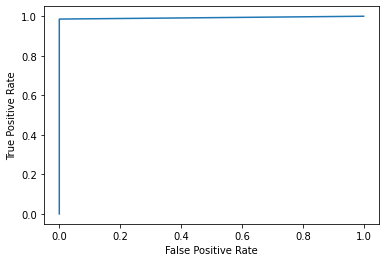

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(y_test,  y_preds)
#buat kurva ROC
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()